<a href="https://colab.research.google.com/github/DerManjuel/MIR/blob/main/Kopie_von_MIR_05_NLP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  <div>
    <h1 align="center">Excercise 05 - Medical Information Retrieval 2023</h1>
  </div>
  <br />

Today, we are moving on, towards a machine learning approach for text classification. 

## Text classification <a class="anchor" id="first"></a>

In the following 3 weeks we are focussing on machine learning approaches on our classification task. Feel free to use any tool which helps you, as long as you can explain, what exactelly is happening, and why it is useful. Given, that you know the preprocessing steps from the past weeks and are able to apply them, we want you to use them now in order to develop a machine learning model for our classification problem.

### Requirements
* The notebook should run **without any error**, given that all packages are installed and the dataset is loaded. When we test it, we will adapt path definitions and might will install nessesary packages)
* Your training/validation script should only use the train split we give you.

### Evaluation
* For evalutation, you can use the function "test_model_performance" in this notebook for accuracy, precision, recall and F1-score. If you choose to use such evaluation, the predicted labels have to be hot-encoded: The output of your model should be a vector of probabilities for each class. 
### Your tasks

* Make an exploratory data analysis
* Develop a preprocessing pipeline
* Train and test one or several machine learning models
* Evaluate the algorithms with a metric of your choice 
* Visualize the outcome

* Prepare a presentation (or present this notebook) of around 10 minutes for our last session (6th of June)


You can start from here. To have a comparable evaluation between each group, we give you a fixed train and test split.

In [ ]:
### loading the dataset ###
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
!pip install torchinfo
from torchinfo import summary
from torch.cuda import amp
!pip install torchmetrics
import torchmetrics as metric
from tqdm.notebook import trange, tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from google.colab import drive
from collections import Counter
import seaborn as sns
import string
import spacy
from spacy import displacy
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers


drive.mount('/content/drive')
path = '/content/drive/MyDrive/MIR-NLP/'
df = pd.read_csv('/content/drive/My Drive/MIR-NLP/mtsamples_clean.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Only use X and y_one_hot or y_classes for training purposes in the rest of the notebook. After running the whole notebook, there should be a prediction from your model, which took X_test as input to create the predictions. Each prediction has to be a vector of length 40.

**Data exploration**

Analysing the data. Visualize most common words and medical spezialities. Remove Stop Words afterwards and tokenize/lemmatize the data.

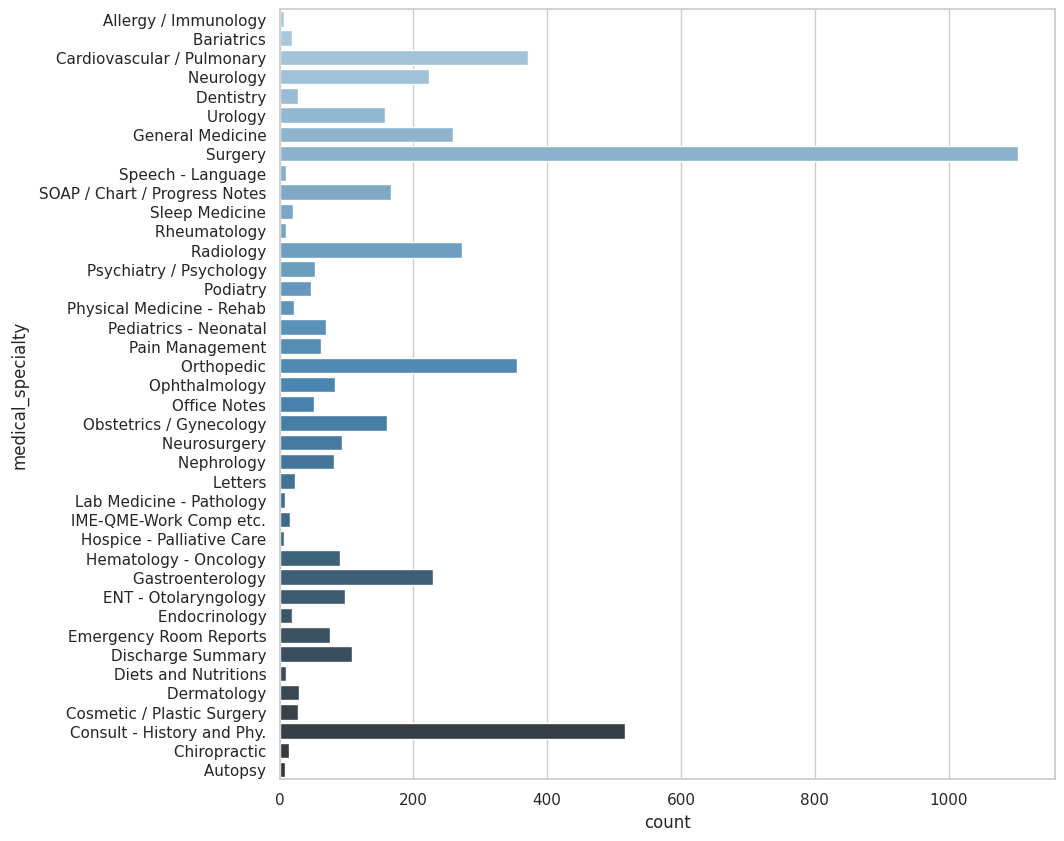

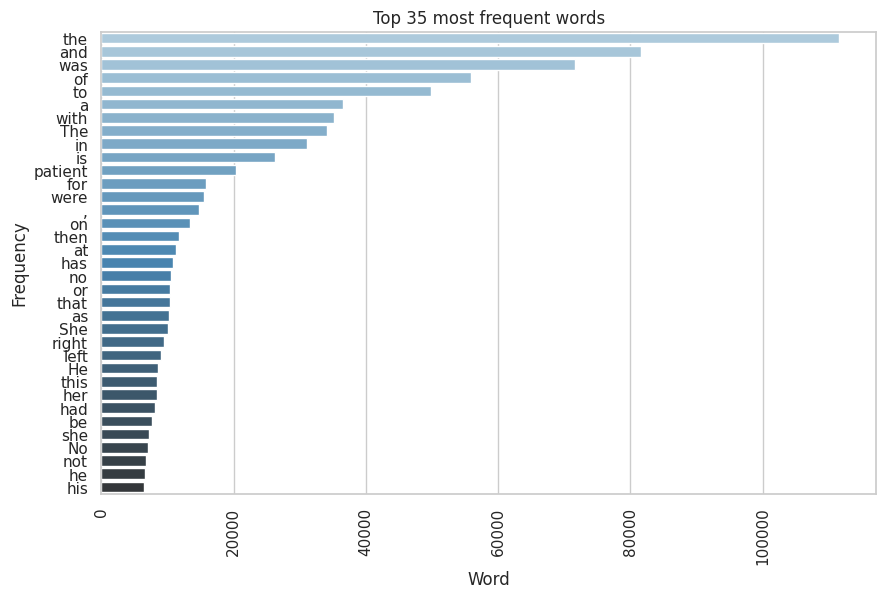

In [ ]:
# inspect data
df.head()

# visualize classes (medical spezialities)
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.countplot(y='medical_specialty', data=df, palette="Blues_d")
plt.show()

# visualize most frequent words
word_counts = Counter()

for note in df["transcription"]:
    word_counts += Counter(str(note).split())

# Visualize the top 20 most frequent words in a bar chart
# Create a dataframe of word counts
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])
word_counts_df.index.name = "word"
word_counts_df.reset_index(inplace=True)

# Filter the top 35 most frequent words
top_words = word_counts_df.nlargest(35, "count")

# Visualize the top 35 most frequent words using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=top_words, y="word", x="count", palette="Blues_d")
plt.title("Top 35 most frequent words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

**Preprocessing**

<ipython-input-20-69cbfb961d66>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df["cleanTranscripts"] = df["cleanTranscripts"].str.replace(r"[{}]".format(string.punctuation), " ")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

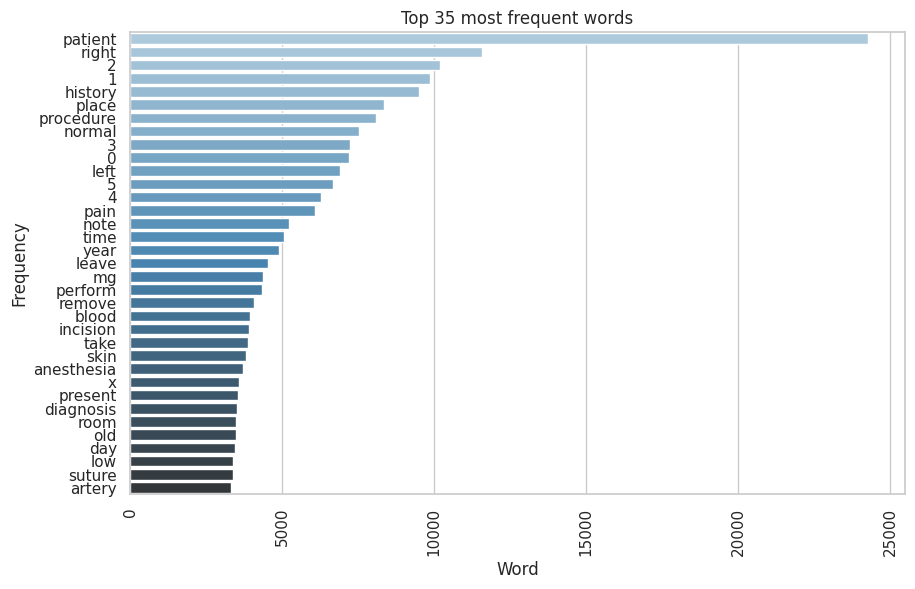

,medical_specialty,transcription,cleanTranscripts,cleanTranscriptsWithoutStopWords
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...",subjective this 23 year old white female pr...,subjective 23 year old white female presen...
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...",past medical history he has difficulty climb...,past medical history difficulty climb stair...
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",history of present illness i have seen abc ...,history present illness see abc today p...
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2 d m mode 1 left atrial enlargement wit...,2 mode 1 leave atrial enlargement left...
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,1 the left ventricular cavity size and wall ...,1 left ventricular cavity size wall thickne...


In [ ]:
# data cleaning
df.dropna()

# Lowercase the transcripts
df['cleanTranscripts'] = df['transcription'].str.lower().astype(str)

# remove punctuation from the notes and replace them with a space
df["cleanTranscripts"] = df["cleanTranscripts"].str.replace(r"[{}]".format(string.punctuation), " ")


nltk.download('stopwords')
# list of stop words
stop_words = stopwords.words('english')
print('stop words:',stop_words)
#stop_words.extend(["the", "and", "was"])


# remove most common stop words from the dataset
# load NLP from spacy
nlp = spacy.load('en_core_web_sm')

for w in stop_words:
    nlp.vocab[w].is_stop = True

# Convert each row into spacy document and return the lemma of the tokens in 
# the document if it is not a sotp word. Finally join the lemmas into as a string
df['cleanTranscriptsWithoutStopWords'] = df["cleanTranscripts"].apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text) 
                                                   if not token.is_stop))

#df["cleanTranscriptsWithoutStopWords"] = [w for w in df["cleanTranscripts"] if w not in stop_words]


# visualize most frequent words again after stop word removal
word_counts = Counter()

for note in df["cleanTranscriptsWithoutStopWords"]:
    word_counts += Counter(str(note).split())

# Visualize the top 20 most frequent words in a bar chart
# Create a dataframe of word counts
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])
word_counts_df.index.name = "word"
word_counts_df.reset_index(inplace=True)
print('word count:',word_counts)

# Filter the top 35 most frequent words
top_words = word_counts_df.nlargest(35, "count")

# Visualize the top 35 most frequent words using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=top_words, y="word", x="count", palette="Blues_d")
plt.title("Top 35 most frequent words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

df.head()

In [ ]:
# tokenize data
tokenizer = WhitespaceTokenizer()

# Tokenize the notes using whitespace tokenizer
df["tokenized"] = df["cleanTranscriptsWithoutStopWords"].apply(tokenizer.tokenize)

# lemmatize words
#nltk.download('WordNet')
nltk.download('wordnet')
nltk.download('omw-1.4')


# import stemmer fromm nltk
lemmatizer = WordNetLemmatizer()

# use stemmer on the dataset
df["lemmatizedTranscripts"] = [lemmatizer.lemmatize(str(word)) for word in df["tokenized"]] #stemmer.stem(df["tokenized"])

# count tokens
token_counts = Counter()

for note in df["tokenized"]:
    token_counts += Counter(str(note).split())

# compare word and token counts
print('word count:',word_counts)
print('token count:',token_counts)

df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


word count: Counter({'patient': 24272, 'right': 11587, '2': 10180, '1': 9871, 'history': 9514, 'place': 8363, 'procedure': 8095, 'normal': 7526, '3': 7247, '0': 7197, 'left': 6919, '5': 6692, '4': 6290, 'pain': 6093, 'note': 5219, 'time': 5070, 'year': 4897, 'leave': 4530, 'mg': 4375, 'perform': 4348, 'remove': 4090, 'blood': 3960, 'incision': 3916, 'take': 3882, 'skin': 3802, 'anesthesia': 3707, 'x': 3585, 'present': 3540, 'diagnosis': 3528, 'room': 3502, 'old': 3498, 'day': 3460, 'low': 3399, 'suture': 3392, 'artery': 3333, 'follow': 3225, '6': 3166, '10': 3103, 'area': 3091, 'general': 3064, 'position': 2990, 'anterior': 2932, 'medication': 2825, 'extremity': 2770, 'disease': 2733, 'past': 2674, 'close': 2650, 'show': 2649, 'chest': 2631, 'mm': 2599, 'examination': 2594, 'obtain': 2587, 'dr': 2562, 'tissue': 2558, 'pressure': 2518, 'fashion': 2504, 'give': 2502, 'deny': 2450, 'neck': 2427, 'cm': 2422, 'good': 2380, 'negative': 2374, 'appear': 2356, 'clear': 2338, 'upper': 2324, 'sur

,medical_specialty,transcription,cleanTranscripts,cleanTranscriptsWithoutStopWords,tokenized,lemmatizedTranscripts
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr...",subjective this 23 year old white female pr...,subjective 23 year old white female presen...,"[subjective, 23, year, old, white, female, pre...","['subjective', '23', 'year', 'old', 'white', '..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb...",past medical history he has difficulty climb...,past medical history difficulty climb stair...,"[past, medical, history, difficulty, climb, st...","['past', 'medical', 'history', 'difficulty', '..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",history of present illness i have seen abc ...,history present illness see abc today p...,"[history, present, illness, see, abc, today, p...","['history', 'present', 'illness', 'see', 'abc'..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2 d m mode 1 left atrial enlargement wit...,2 mode 1 leave atrial enlargement left...,"[2, mode, 1, leave, atrial, enlargement, left,...","['2', 'mode', '1', 'leave', 'atrial', 'enlarge..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,1 the left ventricular cavity size and wall ...,1 left ventricular cavity size wall thickne...,"[1, left, ventricular, cavity, size, wall, thi...","['1', 'left', 'ventricular', 'cavity', 'size',..."


**Vectorization**

In [ ]:
MAX_TOKENS = 40

def indecies_vectorize(X_feature, y_label, max_length = 1500, max_tokens = MAX_TOKENS,):
    '''
    X_feature: df['transcription'].values
    max_length: maximum number of words in one text/document
    max_tokens: the length of vocabulary
    '''
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_label)
    
    text_vectorization = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_length,
        pad_to_max_tokens=True
    )
    # training the text vectorization object
    text_vectorization.adapt(X_feature) 
    # convert preprocessed training text into anrray of integers/indecies
    indecies_array = text_vectorization(X_feature) 
    
    #smote_over_sample = SMOTE(sampling_strategy='minority')
    #X, y = smote_over_sample.fit_resample(indecies_array, y_int)
    
    X = np.array(indecies_array)
    y = np.array(y_int)
    return X, y

Create train and test split and create a model for the classification task.

In [ ]:
### creating train and test split ###
_X, _y = indecies_vectorize(df['lemmatizedTranscripts'], df['medical_specialty'])


#_X = df['lemmatizedTranscripts']
#_y = df['medical_specialty']
_y_one_hot = pd.get_dummies(_y)

X, X_test, y_one_hot, _ = train_test_split(_X, _y_one_hot, test_size=0.2, random_state=123)
_, _, y_classes, _ = train_test_split(_X, _y, test_size=0.2, random_state=123)

In [ ]:
def test_model_performance(y_pred):
    _, _, _, y_test = train_test_split(_X, _y_one_hot, test_size=0.2, random_state=123)

    # set highest to 1 and rest to 0
    #y_pred = np.argmax(y_pred, axis=1)

    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
    print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
### performance of a random guesser ###

y_pred_dummy = np.zeros((len(X_test), 40))
# random predictions with sum 1
y_pred_dummy = y_pred_dummy + np.random.rand(y_pred_dummy.shape[0], y_pred_dummy.shape[1])
y_pred_dummy = y_pred_dummy / y_pred_dummy.sum(axis=1).reshape(-1, 1)

# set only highest value to 1 and rest to 0
y_pred_dummy = np.argmax(y_pred_dummy, axis=1)
y_pred_dummy = pd.get_dummies(y_pred_dummy).values

test_model_performance(y_pred_dummy)

Accuracy:  0.02
Precision:  0.06058831790435453
Recall:  0.02
F1:  0.025623234750927985


**Model**

In [ ]:
# create dataloader for training
train_dataset = list(zip(X, y_one_hot))
val_dataset = list(zip(X_test, y_one_hot))

train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=False, drop_last=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=40, drop_last=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_classes = len(pd.unique(_y))
print(num_classes)

40


In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=17):
        super(ResNetBlock, self).__init__()

        #TODO
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm1d(out_channels),
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size = 17, stride=2, padding=8, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size = 17, stride=1, padding= 8, bias=False),
            nn.BatchNorm1d(out_channels),
        )

        self.relu = nn.ReLU()

    def forward(self, x):

        #TODO
        x1 = self.conv1(x)
        x2 = self.conv2(x)

        x = x1 + x2
        x = self.relu(x)

        return x

In [ ]:
class ResBackbone(nn.Module):
    def __init__(self):
        super().__init__()

        #TODO
        self.input_conv = nn.Sequential(
            nn.Conv1d(in_channels=40, out_channels=1500, kernel_size=17, padding=8, stride=1, bias=False),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
        )

        #TODO
        
        self.backbone = nn.Sequential(
            ResNetBlock(1500, 750), 
            ResNetBlock(750,375),
            ResNetBlock(375,188),
            ResNetBlock(188, 94),
        )

    def forward(self, x):

        x = self.input_conv(x)
        x = self.backbone(x)

        return x

In [ ]:
sample_rate = 300
summary(ResBackbone(), (1, 40, 1500))

Layer (type:depth-idx)                   Output Shape              Param #
ResBackbone                              [1, 94, 94]               --
├─Sequential: 1-1                        [1, 1500, 1500]           --
│    └─Conv1d: 2-1                       [1, 1500, 1500]           1,020,000
│    └─BatchNorm1d: 2-2                  [1, 1500, 1500]           3,000
│    └─ReLU: 2-3                         [1, 1500, 1500]           --
├─Sequential: 1-2                        [1, 94, 94]               --
│    └─ResNetBlock: 2-4                  [1, 750, 750]             --
│    │    └─Sequential: 3-1              [1, 750, 750]             1,126,500
│    │    └─Sequential: 3-2              [1, 750, 750]             28,690,500
│    │    └─ReLU: 3-3                    [1, 750, 750]             --
│    └─ResNetBlock: 2-5                  [1, 375, 375]             --
│    │    └─Sequential: 3-4              [1, 375, 375]             282,000
│    │    └─Sequential: 3-5              [1, 375, 375] 

In [ ]:
class ResBaseline(nn.Module):
    def __init__(self):
        super(ResBaseline, self).__init__()

        self.backbone = ResBackbone()

        #TODO
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.sigmoid = nn.Sigmoid()
        self.classifier = nn.Linear(in_features=94 , out_features=40)#num_classes)#4)

    def forward(self, x):

        #TODO
        x = self.backbone(x)
        x = self.pool(x) 
        x = torch.squeeze(x)
        x = self.sigmoid(x)
        x = self.classifier(x)
 
        
        return x

Root inverse frequency to handle with the unbalanced data

In [ ]:
# Convert y_one_hot DataFrame to numpy array
y_one_hot_array = y_one_hot.to_numpy()

# Calculate the number of recordings
num_recordings = len(y_one_hot_array)

# Calculate the counts of each class
P = np.bincount(y_one_hot_array.flatten()) / num_recordings

# Calculate the class weights
class_weights = np.sqrt(P**-1)

class_weights= torch.from_numpy(class_weights)

print(class_weights)

tensor([0.1601, 1.0000], dtype=torch.float64)


In [ ]:
def train(model, num_epochs, lr_decay=0.95, lr=0.001):

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)

    # learning rate scheduler
    #lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

    # criterion
    criterion = nn.CrossEntropyLoss()#weight=class_weights.float())
    # for reproducibility (do not change)
    torch.manual_seed(0)

    # statistics
    ce_mean = metric.MeanMetric()#.cuda()
    f1_metric = metric.classification.MulticlassF1Score(num_classes)#.cuda()
    best_val_f1 = []
    output_all=[]

    # for num_epochs
    for epoch in trange(num_epochs, unit='epoch'):

        # train mode
        model.train()

        # statistics
        ce_mean.reset()
        f1_metric.reset()

        # for each mini-batch
        for input, target in train_dataloader:
            output = model(input.float())
            output_all.append(output)
            loss = criterion(output, target.float())        

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            # statistics1
            ce_mean(loss)
            f1_metric(output, target)


        # update learning rate
        #lr_scheduler.step()

        # output
        tqdm.write('Epoch {} (train) -- loss: {:.4f} f1: {:.4f}'.format(epoch, ce_mean.compute(), f1_metric.compute()))

        # validate

        # eval mode
        model.eval()

        # statistics
        ce_mean.reset()
        f1_metric.reset()

        # for each mini-batch
        for input, target in val_dataloader:
            output = model(input.float())
         
            loss = criterion(output, target.float())

            # statistics2
            ce_mean(loss)
            f1_metric(output, target)

        # output
        tqdm.write('Epoch {} (valid) -- loss: {:.4f} f1: {:.4f}\n'.format(epoch, ce_mean.compute(), f1_metric.compute()))
        # statistics
        best_val_f1.append(f1_metric.compute().item())
        ce_mean.reset()
        f1_metric.reset()

    # make model callable outside this function
    train.trained_model = model

    # best F1 score
    print('Best F1 score (valid):', '{:.2f}'.format(round(max(best_val_f1), 2)))
    return output_all

In [ ]:
baseline = ResBaseline()#.cuda()
ypred = train(baseline, 10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 (train) -- loss: 2910.9824 f1: 0.0012
Epoch 0 (valid) -- loss: 2874.8379 f1: 0.0013

Epoch 1 (train) -- loss: 2857.0828 f1: 0.0012
Epoch 1 (valid) -- loss: 2836.0835 f1: 0.0012

Epoch 2 (train) -- loss: 2831.6006 f1: 0.0012
Epoch 2 (valid) -- loss: 2815.4734 f1: 0.0012

Epoch 3 (train) -- loss: 2813.9834 f1: 0.0012
Epoch 3 (valid) -- loss: 2800.8389 f1: 0.0012

Epoch 4 (train) -- loss: 2799.6387 f1: 0.0012
Epoch 4 (valid) -- loss: 2786.8892 f1: 0.0012

Epoch 5 (train) -- loss: 2787.5051 f1: 0.0012
Epoch 5 (valid) -- loss: 2776.0691 f1: 0.0012

Epoch 6 (train) -- loss: 2777.1323 f1: 0.0012
Epoch 6 (valid) -- loss: 2767.3660 f1: 0.0013

Epoch 7 (train) -- loss: 2768.2917 f1: 0.0012
Epoch 7 (valid) -- loss: 2761.1685 f1: 0.0013

Epoch 8 (train) -- loss: 2760.7893 f1: 0.0012
Epoch 8 (valid) -- loss: 2755.1362 f1: 0.0014

Epoch 9 (train) -- loss: 2754.5034 f1: 0.0012
Epoch 9 (valid) -- loss: 2750.0361 f1: 0.0014

Best F1 score (valid): 0.00


**Evaluation**

In [ ]:
test_model_performance(ypred)

ValueError: ignored